# Setting up a CNN for CIFAR-10

In this exercise, you are asked to set up a network with convolutional layers, pooling layers, and fully connected layers.
Do the programming and initial tests on CPU, then change to GPUs for effective traning. Change in config below. 
If running on GPU, check that the kernel is using python 3.6, or change the kernel. 



When your code works, change to GPU and follow instructions given elsewhere on how to upload and run from the new ml cluster at USIT. Finish the programming using CPU, and upload your code afterwards. 

You can also finish traning on CPU, this will take 15-30 minutes for CIFAR-10 and up to 20-30 epochs.

In [22]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#from utils.utility_functions import datasetFashionMNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import torchvision.datasets
import torch.utils
import torch.utils.data.dataloader as dataloader

#from graphviz import Digraph
#matplotlib inline

## Load CIFAR-images

You might need to change the data directory. 

In [24]:
#The output of torchvision datasets are PILImage images of range [0, 1]. 
#We transform them to Tensors of normalized range [-1, 1].
# Data
transform_train = transforms.Compose([
    # The crop is to normalize image size to 32x32
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val = transforms.Compose([
    #The crop is to normalize image size to 32
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
CIFAR_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
MNIST_classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

## TODO: if running on the GPU servers, no common data directory is yet available. Change root to ./data and download 
## temporally to your working area on the servers. 


useCifar = True
if useCifar:
    train_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR-10', train=True, download=True, transform=transform_train)
    val_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR-10', train=False, download=True, transform=transform_val)
    classes = CIFAR_classes

else:
    train_dataset = torchvision.datasets.MNIST(root='./data/MNIST', train=True, download=True, transform=transform_train)
    val_dataset = torchvision.datasets.MNIST(root='./data/MNIST', train=False, download=True, transform=transform_val)
    classes = MNIST_classes 

# DataLoader
batch_size=128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


## Inspect some random images 

Note that CIFAR are 3x32x32 images, so your network should reflect the input size, and also the number of  convolutional layers possible given the size of the convolution kernels. 

truck   car  ship  bird   dog   cat  bird truck


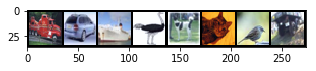

In [25]:
# get some random training images
nofdisplay = 8
train_loader_some = torch.utils.data.DataLoader(train_dataset, batch_size=nofdisplay, shuffle=True)
dataiter = iter(train_loader_some)
images, labels = dataiter.next()
images = images*0.2 + 0.5 #multiply by 0.2 and add 0.5 to approximately reverse the Normalize transform

# show images
def show(img):
    npimg = img.numpy()
    npimg = npimg.transpose((1,2,0))
    plt.imshow(npimg, interpolation='nearest')

# print(torchvision.utils.make_grid(images))
show(torchvision.utils.make_grid(images, padding=2, normalize=True, range=(0, 1)))

# print labels
if useCifar:
    print(' '.join('%5s' % CIFAR_classes[labels[j]] for j in range(nofdisplay)))
else:
    print(' '.join('%5s' % MNIST_classes[labels[j]] for j in range(nofdisplay)))


To keep track of important parameters, we use dictionary "config". You should experiment with different values for the batch size, learning rate and number of epochs trained.


Once your implementation work, you can try to improve the accuracy by changing the parameters, and the architecture.

When your code works with e.g. a couple of epochs, try using the GPU servers to do a longer traning and play with parameters. 

In [26]:
config = {
          'batch_size': 128,
          'use_cuda': False,       #True=use Nvidia GPU | False use CPU
          'log_interval': 20,      #How often to dislay (batch) loss during training
          'epochs': 10,           #Number of epochs
          'learningRate': 0.01,
          'momentum' : 0.9
         }

In [27]:
images.shape

torch.Size([8, 3, 32, 32])

Here we set up initialization and the basic network architecture.

Set up a basic network with 2 convolutional layers, each followed by max pool, uses Relu activation, and has two fully connected layers at the end. For RGB color images, the input layer has 3 band, and for gray level images it only has 1 input band.

Suggestions: Conv-layer 1 can have 6 5x5-filters, ReLU, followed by max pool with size 2.

Conv-layer 2 can initially have 16 5x5-filters, ReLU, followed by maxpool with size 2.

Then reshape the input to match a linear layer. Use initially 3 fully conntectedlayers, with output size 120, 84, and 10.

The number of output nodes in the output layer must correspond to the number of classes, in our case 10.

The resulting network will resemble LeNET, the first pioneering convolutional network, but with ReLU. 

Hint: see the solution to the exercise in week 5. Use nn.Conv2D, nn. MaxPool2d, and nn.Linear


In [28]:
def compute_output_layer_shape(h, \
                               w, \
                               kernel_height_list, \
                               kernel_width_list, \
                               pad_size_list, \
                               stride_list):
    
    
    num_conv = len(stride_list)
    
    for i in range(num_conv):
    
        # Formula for the spatial dimensions of an image
        # in an convolutional output layer.
        h, w = np.int(np.floor(1 + (h + 2*pad_size_list[i] - kernel_height_list[i])/stride_list[i])), \
                np.int(np.floor(1 + (w + 2*pad_size_list[i] - kernel_width_list[i])/stride_list[i]))
    
    return h, w


class Model(nn.Module):
     
    def __init__(self):
        super(Model, self).__init__()
        #Start with the solution to the first pytorch exercise. 
        
        kernel_height_list = [5, 2, 5, 2]
        kernel_width_list = [5, 2, 5, 2]
        pad_size_list = [0, 0, 0, 0]
        stride_list = [1, 2, 1, 2]
        
        self.c1 = nn.Conv2d(3, 6, kernel_size=5)
        # 32x32 is cifar10 specific.
        #self.h1, self.w1 = compute_output_layer_shape(32, 32, 5, 5, 0, 1)
        
        self.mp = nn.MaxPool2d(kernel_size=2)
        #self.h2, self.w2 = compute_output_layer_shape(self.h1, self.w1, 2, 2, 0, 2)
                
        self.c2 = nn.Conv2d(6, 20, kernel_size=5)
        #self.h3, self.w3 = compute_output_layer_shape(self.h2, self.w2, 5, 5, 0, 1)
        
        # Because we have two max pool layers.
        # This is the last layer that changes image dimensions
        # (but not channel dimensions).
        
        
        #self.h, self.w = compute_output_layer_shape(self.h3, self.w3, 2, 2, 0, 2)
        self.h, self.w = compute_output_layer_shape(32, \
                               32, \
                               kernel_height_list, \
                               kernel_width_list, \
                               pad_size_list, \
                               stride_list)
        
        
        
        
        # While a convolution layer take in number of channels (the number of 2D or 3D tensors),
        # a linear (fully connected) layer take in number of features (a long 1D vector).
        self.fc1 = nn.Linear(20*self.h*self.w, 120)
        #self.fc1 = nn.Linear(self.in_features, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
        
    def forward(self, x):
        
        #print(x.shape)
        
        # Let x propage from input to output.
        # Take care by reshaping using x.view when flattening the data from convolutional to fully connected layers.
        
        x = self.c1(x)
        x = F.relu(x)
        x = self.mp(x)
                
        x = self.c2(x)
        x = F.relu(x)
        x = self.mp(x)
        
        #x = torch.reshape(x, (x.shape[0], 16*self.h*self.w))
        x = x.view(-1,x.shape[1]*x.shape[2]*x.shape[3])
        #x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        
        return x

In [29]:
# Creat an instance of Model
model = Model()
if config['use_cuda'] == True:
    model.to('cuda')

In [30]:
5//2

2

## Step 3: Define optimizer and loss function

Instantiate an optimizer, e.g. stochastic gradient descent, from the "torch.optim" module (https://pytorch.org/docs/stable/optim.html) with your model. Remember that we have defined "learning rate" inside the config-dictionary.



In [31]:
# Create an instance of "torch.optim.SGD"
import torch.optim as optim

#ToDo
# Try with and without momentum, and with Adam
optimizer = optim.SGD(model.parameters(), lr=config['learningRate'])

Here we want to define the loss function (often called criterion). As we are dealing with a classification problem, you should use the softmax cross entropy loss.

Hint, have a look here: (https://pytorch.org/docs/stable/nn.html#torch-nn-functional)

In [32]:
def loss_fn(prediction, labels):
    """Returns softmax cross entropy loss."""
    #ToDo
    import torch.nn.functional as F
    loss = F.cross_entropy(input=prediction, target=labels)
   
    
    return loss

## Step 4: Set up the training process and train the model

You have all the building blocks needed to set up the training process. You will implement the function "run_epoch" which shall loop though a dataset and train the model.

In [33]:
def run_epoch(model, epoch, data_loader, optimizer, is_training, config):
    """
    Args:
        model        (obj): The neural network model
        epoch        (int): The current epoch
        data_loader  (obj): A pytorch data loader "torch.utils.data.DataLoader"
        optimizer    (obj): A pytorch optimizer "torch.optim"
        is_training (bool): Whether to use train (update) the model/weights or not. 
        config      (dict): Configuration parameters

    Intermediate:
        totalLoss: (float): The accumulated loss from all batches. 
                            Hint: Should be a numpy scalar and not a pytorch scalar

    Returns:
        loss_avg         (float): The average loss of the dataset
        accuracy         (float): The average accuracy of the dataset
        confusion_matrix (float): A 10x10 matrix
    """
    
    if is_training==True: 
        model.train()
    else:
        model.eval()

    total_loss        = 0 
    correct          = 0 
    confusion_matrix = np.zeros(shape=(10,10))
    labels_list      = [0,1,2,3,4,5,6,7,8,9]

    for batch_idx, data_batch in enumerate(data_loader):
        if config['use_cuda'] == True:
            images = data_batch[0].to('cuda') # send data to GPU
            labels = data_batch[1].to('cuda') # send data to GPU
        else:
            images = data_batch[0]
            labels = data_batch[1]

        if not is_training:
            with torch.no_grad():
                # ToDo: Forward
                predictions = model.forward(images)
                
                # ToDo: Compute loss
                # Note: It can be beneficial to detach "total_loss" from the graph, consider convert "total_loss" to numpy.
                loss        = loss_fn(predictions, labels)
                total_loss  += loss.detach().cpu().numpy()
            
        elif is_training: 
            
            # ToDo: Forward
            predictions = model.forward(images)
            
            # ToDo: Compute loss
            # Note: It can be beneficial to detach "total_loss" from the graph, consider convert "total_loss" to numpy.
            loss        = loss_fn(predictions, labels)
            total_loss += loss.detach().cpu().numpy()

            # ToDo: take a gradient update
            optimizer.zero_grad()
            # Propagate gradients
            loss.backward()
            # Update weights
            optimizer.step()
            

        # Compute the correct classification
        predicted_label  = predictions.max(1, keepdim=True)[1][:,0]
        correct          += predicted_label.eq(labels).cpu().sum().numpy()
        confusion_matrix += metrics.confusion_matrix(labels.cpu().numpy(), predicted_label.cpu().numpy(), labels_list)

        # Print statistics
        batchSize = len(labels)
        if batch_idx % config['log_interval'] == 0:
            print(f'Epoch={epoch} | {batch_idx/len(data_loader)*100:.2f}% | loss = {loss/batchSize:.5f}')

    loss_avg         = total_loss / len(data_loader)
    accuracy         = correct / len(data_loader.dataset)
    if  is_training:
        #print(correct)
        #print(len(data_loader.dataset))
        print('Current training accuracy:', accuracy)
    if not is_training:
    #    print(correct)
    #    print(len(data_loader.dataset))
        print('Current validation accuracy',accuracy)
    confusion_matrix = confusion_matrix / len(data_loader.dataset)

    return loss_avg, accuracy, confusion_matrix


In [34]:
#for i, b in enumerate(val_loader):
#    print(b[0].shape)

In [35]:
# training the model
train_loss = np.zeros(shape=config['epochs'])
train_acc  = np.zeros(shape=config['epochs'])
val_loss   = np.zeros(shape=config['epochs'])
val_acc    = np.zeros(shape=config['epochs'])
val_confusion_matrix   = np.zeros(shape=(10,10,config['epochs']))
train_confusion_matrix = np.zeros(shape=(10,10,config['epochs']))
init_lr = config['learningRate']

for epoch in range(config['epochs']):
        
    #lr = init_lr * (0.1 ** (epoch // 20))
    #config['learningRate']=lr
    
    train_loss[epoch], train_acc[epoch], train_confusion_matrix[:,:,epoch] = \
                               run_epoch(model, epoch, train_loader, optimizer, is_training=True, config=config)

    val_loss[epoch], val_acc[epoch], val_confusion_matrix[:,:,epoch]     = \
                               run_epoch(model, epoch, val_loader, optimizer, is_training=False, config=config)


Epoch=0 | 0.00% | loss = 0.01801
Epoch=0 | 5.12% | loss = 0.01801
Epoch=0 | 10.23% | loss = 0.01804
Epoch=0 | 15.35% | loss = 0.01799
Epoch=0 | 20.46% | loss = 0.01793
Epoch=0 | 25.58% | loss = 0.01789
Epoch=0 | 30.69% | loss = 0.01801
Epoch=0 | 35.81% | loss = 0.01794
Epoch=0 | 40.92% | loss = 0.01783
Epoch=0 | 46.04% | loss = 0.01783
Epoch=0 | 51.15% | loss = 0.01761
Epoch=0 | 56.27% | loss = 0.01761
Epoch=0 | 61.38% | loss = 0.01772
Epoch=0 | 66.50% | loss = 0.01742
Epoch=0 | 71.61% | loss = 0.01760
Epoch=0 | 76.73% | loss = 0.01772
Epoch=0 | 81.84% | loss = 0.01766
Epoch=0 | 86.96% | loss = 0.01759
Epoch=0 | 92.07% | loss = 0.01684
Epoch=0 | 97.19% | loss = 0.01680
Current training accuracy: 0.13514
Epoch=0 | 0.00% | loss = 0.01693
Epoch=0 | 25.32% | loss = 0.01734
Epoch=0 | 50.63% | loss = 0.01726
Epoch=0 | 75.95% | loss = 0.01674
Current validation accuracy 0.1717
Epoch=1 | 0.00% | loss = 0.01741
Epoch=1 | 5.12% | loss = 0.01686
Epoch=1 | 10.23% | loss = 0.01693
Epoch=1 | 15.35% 

Epoch=9 | 40.92% | loss = 0.01028
Epoch=9 | 46.04% | loss = 0.01080
Epoch=9 | 51.15% | loss = 0.01022
Epoch=9 | 56.27% | loss = 0.01019
Epoch=9 | 61.38% | loss = 0.01057
Epoch=9 | 66.50% | loss = 0.01102
Epoch=9 | 71.61% | loss = 0.01093
Epoch=9 | 76.73% | loss = 0.01024
Epoch=9 | 81.84% | loss = 0.01095
Epoch=9 | 86.96% | loss = 0.01076
Epoch=9 | 92.07% | loss = 0.01094
Epoch=9 | 97.19% | loss = 0.01112
Current training accuracy: 0.4988
Epoch=9 | 0.00% | loss = 0.01342
Epoch=9 | 25.32% | loss = 0.01389
Epoch=9 | 50.63% | loss = 0.01429
Epoch=9 | 75.95% | loss = 0.01243
Current validation accuracy 0.3954


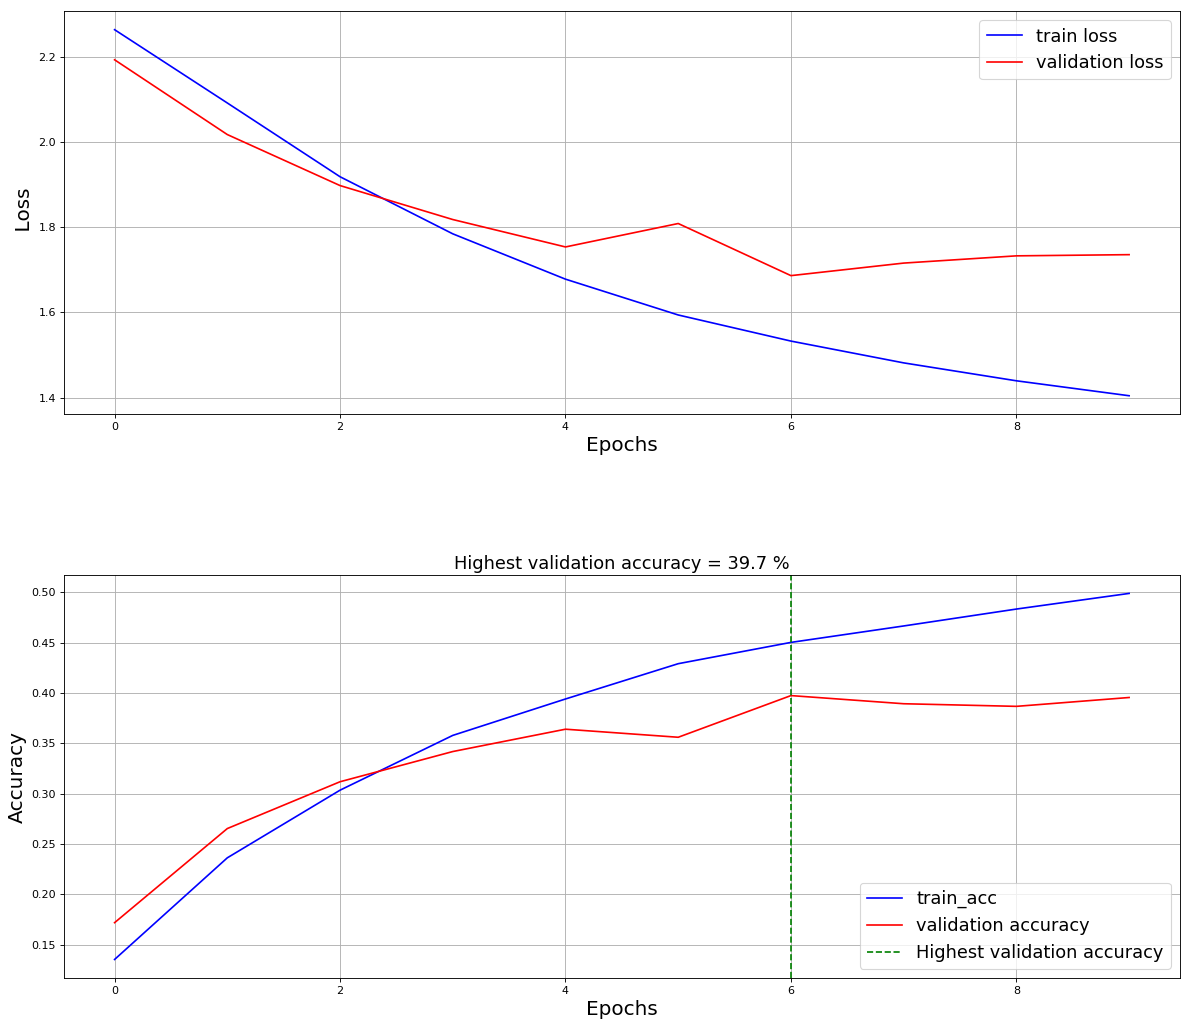

In [36]:
# Plot the training accuracy and the training loss
#plt.figure()
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(2, 1, 1)
# plt.subplots_adjust(hspace=2)
ax.plot(train_loss, 'b', label='train loss')
ax.plot(val_loss, 'r', label='validation loss')
ax.grid()
plt.ylabel(' Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
ax.legend(loc='upper right', fontsize=16)

ax = plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.4)
ax.plot(train_acc, 'b', label='train_acc')
ax.plot(val_acc, 'r', label='validation accuracy')
ax.grid()
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
val_acc_max = np.max(val_acc)
val_acc_max_ind = np.argmax(val_acc)



plt.axvline(x=val_acc_max_ind, color='g', linestyle='--', label='Highest validation accuracy')
plt.title('Highest validation accuracy = %0.1f %%' % (val_acc_max*100), fontsize=16)
ax.legend(loc='lower right', fontsize=16)
plt.ion()

In [37]:
ind = np.argmax(val_acc)
class_accuracy = val_confusion_matrix[:,:,ind]
for ii in range(len(classes)):
    acc = val_confusion_matrix[ii,ii,ind] / np.sum(val_confusion_matrix[ii,:,ind])
    print(f'Accuracy of {str(classes[ii]).ljust(15)}: {acc*100:.01f}%')

Accuracy of plane          : 45.4%
Accuracy of car            : 53.0%
Accuracy of bird           : 6.1%
Accuracy of cat            : 33.2%
Accuracy of deer           : 22.9%
Accuracy of dog            : 31.7%
Accuracy of frog           : 61.5%
Accuracy of horse          : 49.4%
Accuracy of ship           : 50.1%
Accuracy of truck          : 44.0%


## How to improve

Now we have trained a basic network. Try using different learning rates, e.g. from 0.1, 0.01, 0.001 and smaller.

How does the learning loss function and the accuracy for the traning set look? 

What does it mean when the accuracy of the traning data set is much lower than on the traning data set?


Note that we have no regularization, so the generalization ability of the network is likely to be limited. 


## Further work

Try to change the architecture, optimizer and the learning rate. Does the performance improve?